# Régression ZeroInflated

## Cloner la branche contenant le dataset et le code qui va avec.

In [1]:
!rm -rf ActuarialThesis
!git clone https://github.com/aderdouri/ActuarialThesis.git
%ls -ltr ActuarialThesis

Cloning into 'ActuarialThesis'...
remote: Enumerating objects: 853, done.
remote: Counting objects: 100% (136/136), done.
remote: Compressing objects: 100% (98/98), done.
remote: Total 853 (delta 65), reused 100 (delta 37), pack-reused 717
Receiving objects: 100% (853/853), 123.09 MiB | 19.68 MiB/s, done.
Resolving deltas: 100% (355/355), done.
total 96
drwxr-xr-x 2 root root  4096 Oct 21 15:00 AllstateClaimPredictionChallenge/
drwxr-xr-x 2 root root  4096 Oct 21 15:00 AllstateClaimsSeverity/
drwxr-xr-x 2 root root  4096 Oct 21 15:00 Data/
drwxr-xr-x 2 root root  4096 Oct 21 15:00 EMTboost/
drwxr-xr-x 2 root root  4096 Oct 21 15:00 FrenchMotorThirdPartyLiabilityClaims/
drwxr-xr-x 2 root root  4096 Oct 21 15:00 Models/
-rw-r--r-- 1 root root    54 Oct 21 15:00 README.md
drwxr-xr-x 2 root root  4096 Oct 21 15:00 Plots/
drwxr-xr-x 2 root root  4096 Oct 21 15:00 Notebooks/
-rw-r--r-- 1 root root 19545 Oct 21 15:00 myXGBoostRegressor.ipynb
-rw-r--r-- 1 root root 18517 Oct 21 15:00 myLightGB

In [2]:
!mkdir ActuarialThesis/plots_rgr
!ls -ltr ActuarialThesis/plots_rgr

total 0


In [3]:
# Ajouter le répértoire src
import sys
sys.path.insert(0,'./ActuarialThesis/src/')

In [4]:
import installHelper

In [5]:
# Installer les packages nécéssaires
%time installHelper.installALL()

CPU times: user 537 ms, sys: 96.8 ms, total: 634 ms
Wall time: 2min 14s


In [6]:
# On doit trouver tous les packages mentionés dans le grep
!pip list -v | grep -e catboost -e 'imbalanced-learn' -e 'optuna' -e 'catboost' -e 'lime' -e 'shap'

catboost                         1.2.2                 /usr/local/lib/python3.10/dist-packages pip
imbalanced-learn                 0.10.1                /usr/local/lib/python3.10/dist-packages pip
lime                             0.2.0.1               /usr/local/lib/python3.10/dist-packages pip
optuna                           3.4.0                 /usr/local/lib/python3.10/dist-packages pip
shap                             0.43.0                /usr/local/lib/python3.10/dist-packages pip
shapely                          2.0.2                 /usr/local/lib/python3.10/dist-packages pip


In [7]:
from helper import *

Partir du dataset déjà encodé.

In [8]:
df = pd.read_csv('ActuarialThesis/Data/encodedBASEAUTO.csv')
df.head()

,ACV,SEX,STATUT,AGECOND,K8000,RM,CAR,USAGE_Prive,USAGE_PriveTrajet,USAGE_Professionnel,...,SEGM_H,SEGM_M1,SEGM_M2,GARAGE_ClosCollectif,GARAGE_GarageAutre,GARAGE_IndividuelClos,CSP_CSP_50,CSP_CSP_60,CSP_CSP_AUTRE,CHARGE
0,1.134929,1,1,-0.457663,0,-0.094064,0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,1.134929,1,0,1.101165,0,-0.817279,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,1.134929,1,1,-1.813166,0,1.507343,0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,1.134929,1,0,0.626739,0,-0.817279,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,1.134929,1,0,-1.203190,0,1.507343,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [9]:
X = df.drop('CHARGE', axis=1)
y = df['CHARGE']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=13)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=13)

In [36]:
xgb = XGBRegressor(objective='reg:squarederror',
                   n_estimators=5000,
                   learning_rate=0.001,
                   max_depth=4,
                   gamma=1,
                   subsample=0.5,
                   random_state=13)

lgb = LGBMRegressor(objective='regression',
                    n_estimators=5000,
                    learning_rate=0.001,
                    max_depth=3,
                    lambda_l2=1.0,
                    boosting_type='goss',
                    verbose = -1,
                    random_state=13)

cb = CatBoostRegressor(loss_function='RMSE',
                       iterations=5000,
                       learning_rate=0.001,
                       max_depth=9,
                       verbose=False,
                       random_state=13)

lr = LogisticRegression(class_weight='balanced', solver='saga')
model_lasso = Lasso(alpha=10.0, random_state=131)


rf_clf = RandomForestClassifier(random_state=0)
rf_rgr = RandomForestRegressor(random_state=0)

## Régression Zero-Infalted : LogisticRegression, Lasso

In [37]:
# Instantiate the zero-inflated regressor.
zir = ZeroInflatedRegressor(
    classifier=lr,
    regressor=cb
)

# Fit zero-inflated regressor
zir.fit(X_train, y_train)

y_pred = zir.predict(X_val)
loss = mean_squared_error(y_val, y_pred, squared=False)

y_pred_zir = zir.predict(X_test)
print("Best rmse:", mean_squared_error(y_pred_zir, y_test, squared=False))
print("R2 using Zir: ", r2_score(y_test, y_pred_zir ))

The max_iter was reached which means the coef_ did not converge


Best rmse: 1846.9223737030443
R2 using Zir:  0.0037737555685581903


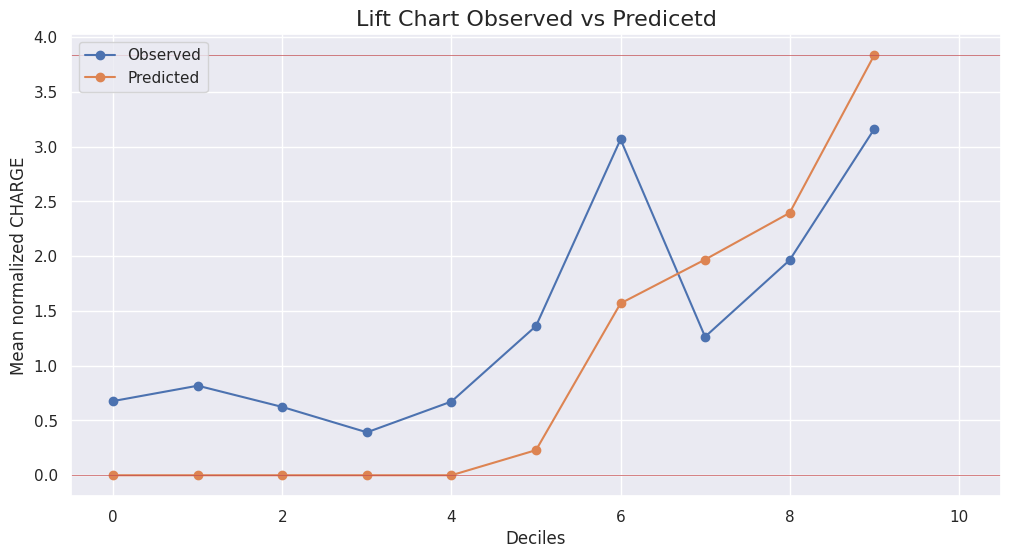

In [38]:
df_ObsVsPred = df_ObservedVsPredicted(y_test, y_pred_zir)
fig, ax = plotLiftChart(df_ObsVsPred)
fig.savefig('./ActuarialThesis/plots_rgr/myZIRLassoLiftChart.pdf')

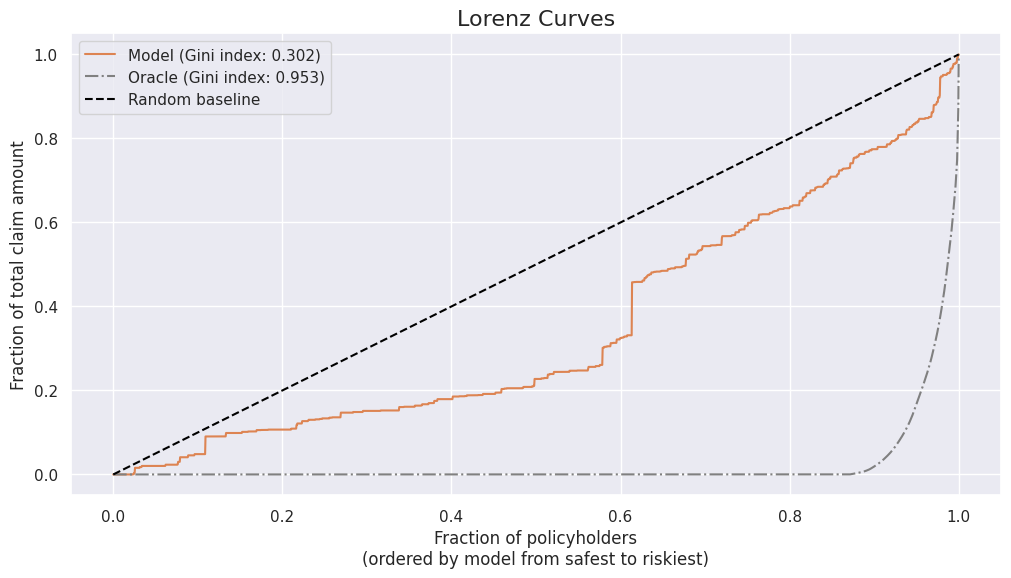

In [39]:
df_ObsVsPred = df_ObservedVsPredicted(y_test, y_pred_zir)
fig, ax = plotLorenzCurve(df_ObsVsPred)
fig.savefig('./ActuarialThesis/plots_rgr/myZIRLassoLorenzCurve.pdf')

## Régression Zero-Infalted : LogisticRegression, XGBRegressor

In [17]:
# Instantiate the zero-inflated regressor.
zir = ZeroInflatedRegressor(
    classifier=lr,
    regressor=xgb)

# Fit zero-inflated regressor
zir.fit(X_train, y_train)

y_pred = zir.predict(X_val)
loss = mean_squared_error(y_val, y_pred, squared=False)

y_pred_zir = zir.predict(X_test)
print("Best rmse:", mean_squared_error(y_pred_zir, y_test, squared=False))
print("R2 using Zir: ", r2_score(y_test, y_pred_zir ))

The max_iter was reached which means the coef_ did not converge


Best rmse: 1867.3433748593757
R2 using Zir:  -0.018378129889651706


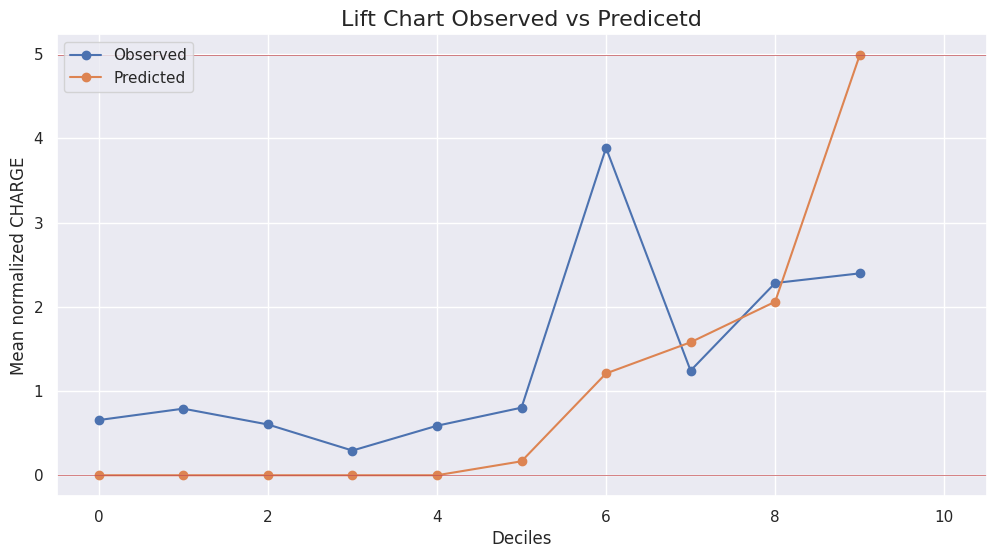

In [18]:
df_ObsVsPred = df_ObservedVsPredicted(y_test, y_pred_zir)
fig, ax = plotLiftChart(df_ObsVsPred)
fig.savefig('./ActuarialThesis/plots_rgr/myZIRXGBoostLiftChart.pdf')

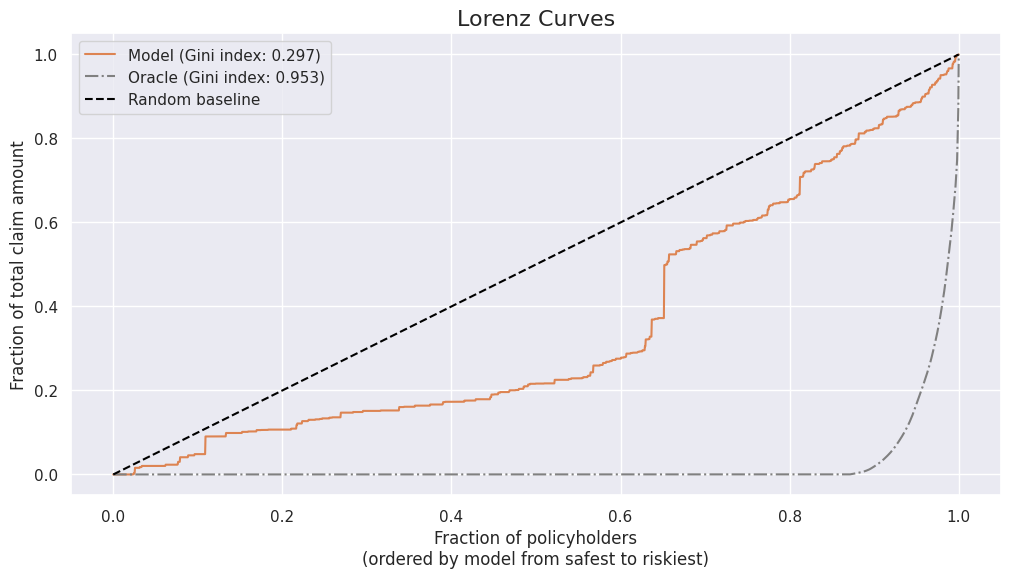

In [19]:
df_ObsVsPred = df_ObservedVsPredicted(y_test, y_pred_zir)
fig, ax = plotLorenzCurve(df_ObsVsPred)
fig.savefig('./ActuarialThesis/plots_rgr/myZIRXGBoostLorenzCurves.pdf')

## Régression Zero-Infalted : LogisticRegression, LGBMRegressor

In [31]:
# Instantiate the zero-inflated regressor.
zir = ZeroInflatedRegressor(
    classifier=lr,
    regressor=lgb)

# fit zero-inflated regressor
zir.fit(X_train, y_train)

y_pred = zir.predict(X_val)
loss = mean_squared_error(y_val, y_pred, squared=False)

y_pred_zir = zir.predict(X_test)
print("Best rmse:", mean_squared_error(y_pred_zir, y_test, squared=False))
print("R2 using Zir: ", r2_score(y_test, y_pred_zir ))

The max_iter was reached which means the coef_ did not converge


Best rmse: 1848.821900984914
R2 using Zir:  0.001723499330221534


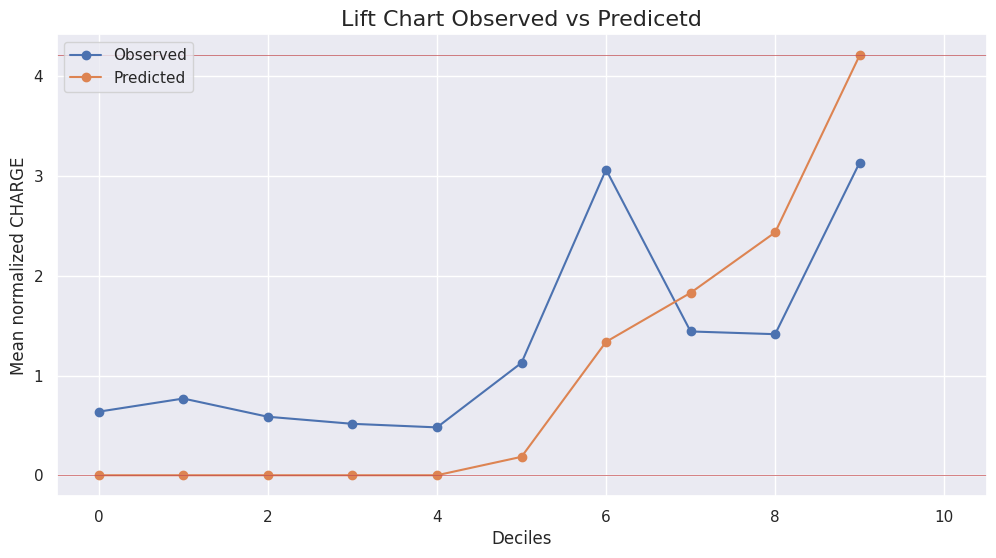

In [32]:
df_ObsVsPred = df_ObservedVsPredicted(y_test, y_pred_zir)
fig, ax = plotLiftChart(df_ObsVsPred)
fig.savefig('./ActuarialThesis/plots_rgr/myZIRLGBMBoostLiftChart.pdf')

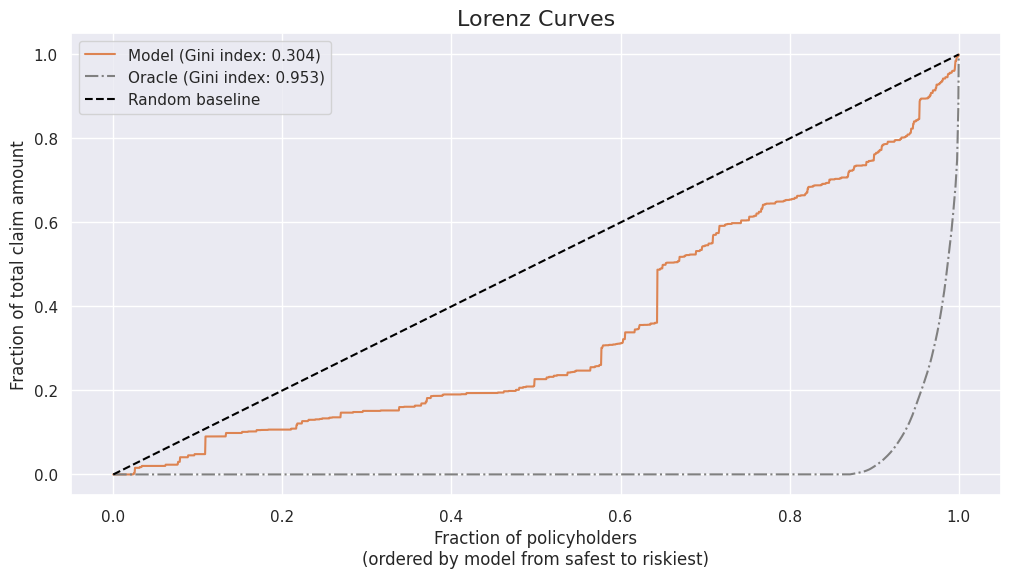

In [33]:
df_ObsVsPred = df_ObservedVsPredicted(y_test, y_pred_zir)
fig, ax = plotLorenzCurve(df_ObsVsPred)
fig.savefig('./ActuarialThesis/plots_rgr/myZIRLGBMBoostLorenzCurves.pdf')

## Régression Zero-Infalted : LogisticRegression, CatboostRegressor

In [40]:
# Instantiate the zero-inflated regressor.
zir = ZeroInflatedRegressor(
    classifier=lr,
    regressor=cb)

# fit zero-inflated regressor
zir.fit(X_train, y_train)

y_pred = zir.predict(X_val)
loss = mean_squared_error(y_val, y_pred, squared=False)

y_pred_zir = zir.predict(X_test)
print("Best rmse:", mean_squared_error(y_pred_zir, y_test, squared=False))
print("R2 using Zir: ", r2_score(y_test, y_pred_zir ))

The max_iter was reached which means the coef_ did not converge


Best rmse: 1846.9223737030443
R2 using Zir:  0.0037737555685581903


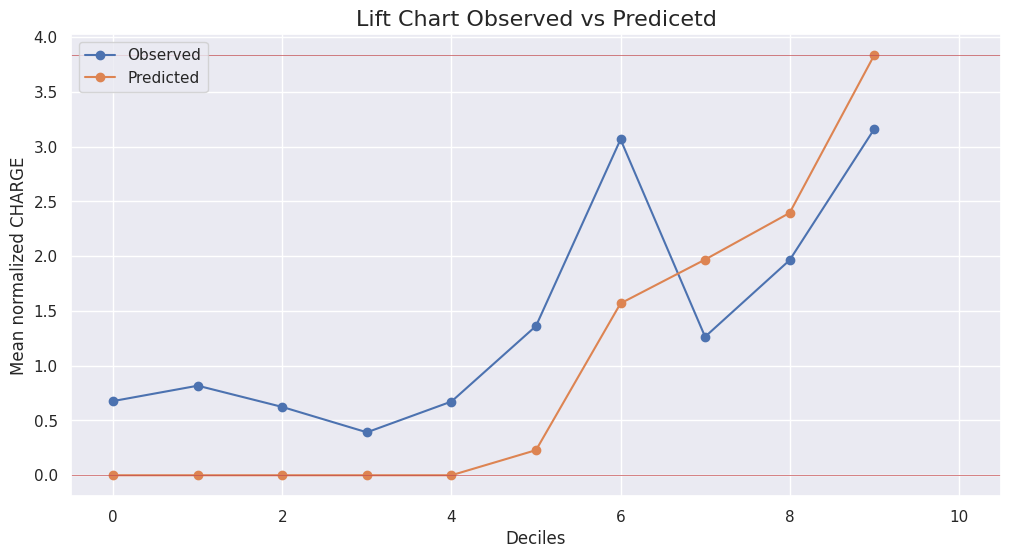

In [24]:
df_ObsVsPred = df_ObservedVsPredicted(y_test, y_pred_zir)
fig, ax = plotLiftChart(df_ObsVsPred)
fig.savefig('./ActuarialThesis/plots_rgr/myZIRCatBoostLiftChart.pdf')

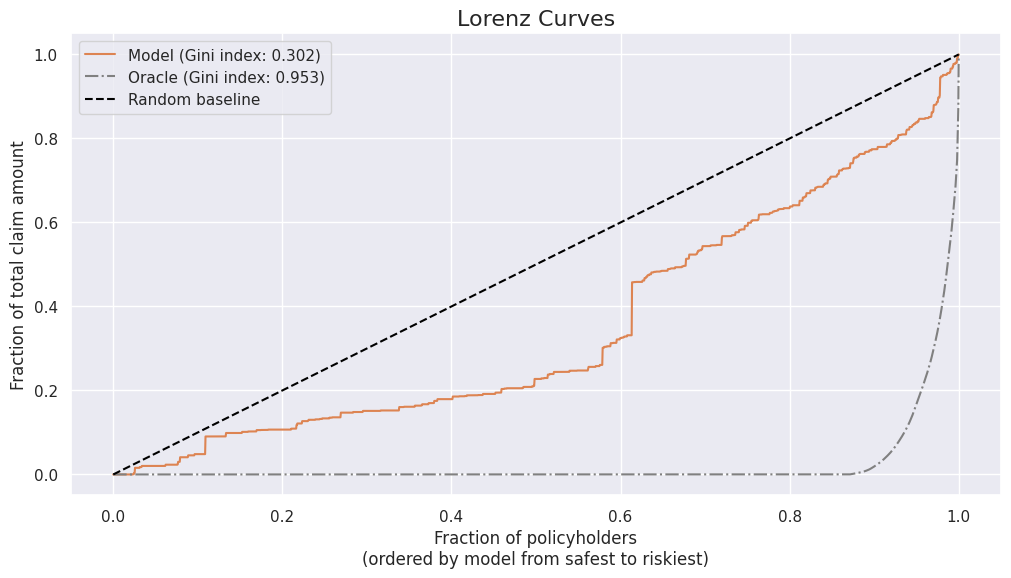

In [25]:
df_ObsVsPred = df_ObservedVsPredicted(y_test, y_pred_zir)
fig, ax = plotLorenzCurve(df_ObsVsPred)
fig.savefig('./ActuarialThesis/plots_rgr/myZIRCatBoostLorenzCurves.pdf')

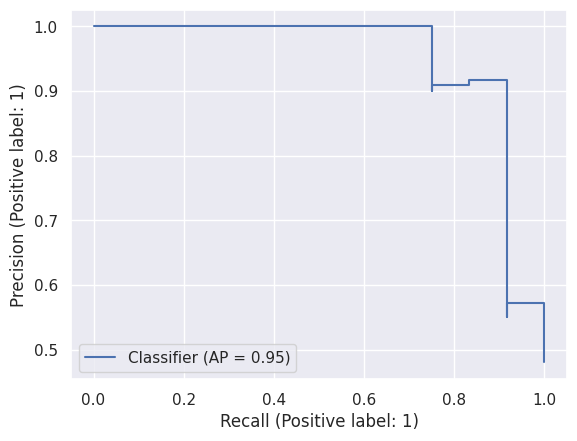

In [45]:
# Importing the libraries and functions
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Building a model
X, y = make_classification(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(
        X, y, random_state=0)
clf = LogisticRegression()
clf.fit(X_train, y_train)

# Getting the predictions
y_pred = clf.predict_proba(X_test)[:, 1]

# Computing and visualizing the PR curve
# Sklearn automatically displays AUC-PR value on an image
PrecisionRecallDisplay.from_predictions(y_test, y_pred)
plt.show()